In [31]:
#| include: false

%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
import torch
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Link to perceptron implementation: [perceptron.py](https://github.com/vikramv17/vikramv17.github.io/blob/main/posts/implementing-the-perceptron-algorithm/perceptron.py)

# Abstract
This blog post attempts to implement a simple perceptron algorithm for binary classification. The perceptron algorithm is a simple linear classifier that is used to classify data into two classes. The algorithm is based on the concept of a threshold function that takes in the input features and weights and returns a binary output. The perceptron algorithm is trained using a simple update rule that adjusts the weights based on the error (loss) in the prediction. The algorithm is trained using a simple gradient descent algorithm that minimizes the error in the prediction. The perceptron algorithm is a simple and efficient algorithm that can be used to classify data into two classes. 

# Implement Perceptron
## Understanding perceptron.grad()
To implement the perceptron algorithm we use gradient descent and the grad function of the algorithm performs this for us. The first step to do this is to convert the output variables from 0 and 1 to -1 and 1 so that the math works. Once this is done we calculate scored for the observations. We then compare these scores to the actual labels to identify the misclassified points. We then use matrix multiplication with X and y to calculate the gradient. The matrix multiplication works to effectively calculate a weighted sum of the feature vectors for the misclassified points. This is then normalized by the number of points and multiplied by the learning rate to get the gradient. The gradient is then returned and is used by the step function to update the weights.

# Experiments
To test our perceptron algorithm we will run some experiments and create visualizations. In order to do this we will need to make datasets to test on. We will use the perceptron_data function to quickly make random datasets with the desired number of dimensions. We will also add a separable parameter to allow us to make datasets that are not linearly separable by adding more noise. This will be needed for some of the experiments. We also define a couple of graphing functions that will help us to plot the perceptron data along with the calculated thresholds.

In [36]:
plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234567)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2, separable = True):
    
    # Generate labels (first half 0, second half 1)
    y = torch.arange(n_points) >= int(n_points / 2)

    # Generate linearly separable data
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))

    if not separable:
        # Add additional noise to make the data non-linearly separable
        X += torch.normal(0.0, noise * 2, size=X.shape)

    # Add a bias term (column of ones)
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    return X, y

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

## Check Implementation
Before we move to the experiments we want to ensure that our algorithm is working as intended. To do this we will perform a minimal training loop to ensure that the loss converges to 0 on linearly separable data.

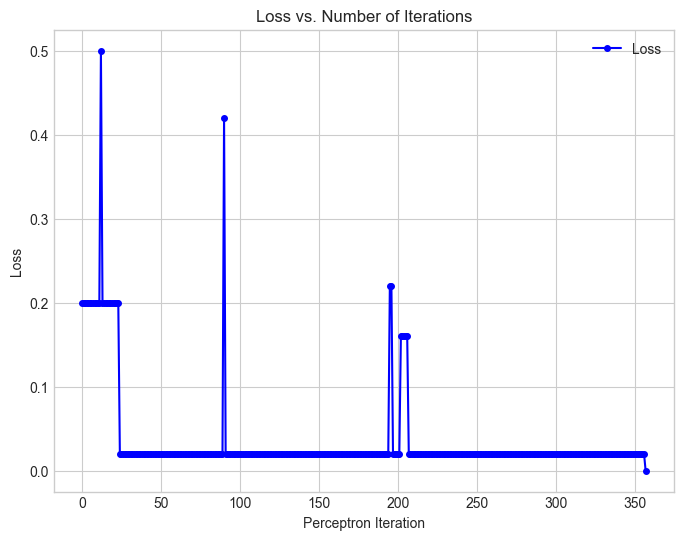

In [131]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

X, y = perceptron_data(n_points = 50, noise = 0.3, separable = True)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y)
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plt.figure(figsize=(8, 6))
plt.plot(loss_vec, marker='o', color='blue', label='Loss', markersize=4)
plt.xlabel('Perceptron Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Iterations')
plt.grid(True)
plt.legend()
plt.show()

As we can see in the above plot, the perceptron algorithm is able to correctly work its way to a loss of zero indicating to us that the algorithm is working as intended.

## Experiment 1
The first experiment involves linearly separable 2-dimensional data. We will create a dataset with 50 points and plot it as shown below.

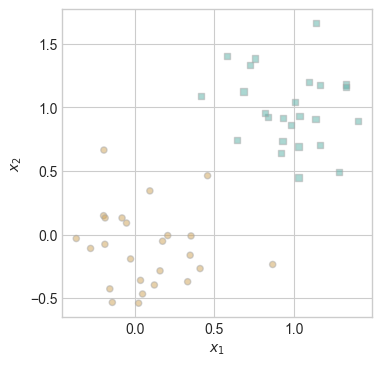

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data(n_points = 50, noise = 0.3, separable = True)
plot_perceptron_data(X, y, ax)

With this data we will run our algorithm and visualize the results. We will plot the data and the decision boundary along with the previous decision boundary as the iterations continue to improve the loss. To perform the training we are selecting a random point and seeing if it was misclassified. If it was we call the step function to update the weights. The loop stops when the loss is zero indicating that the data has been completely separated by the threshold.

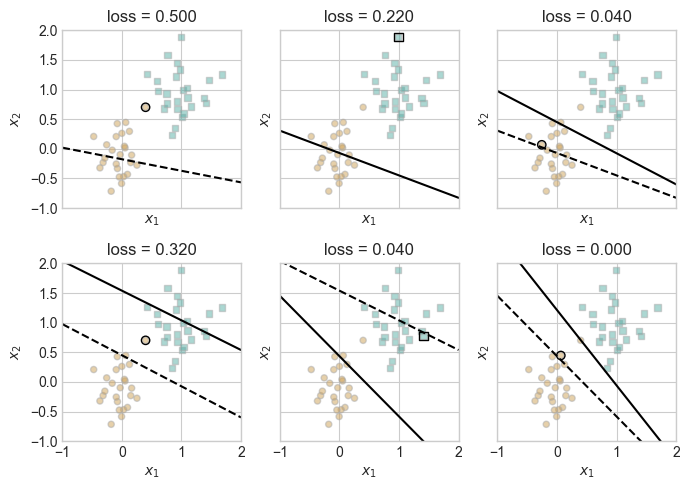

In [ ]:
# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

As we can see, the algorithm works from a random guess to a threshold that perfectly separates the data. The final plot shows this separation and the loss of zero confirms that the data has been completely separated.

## Experiment 2
The second experiment involves 2-dimensional data that is not linearly separable. We will create a dataset with 50 points and plot it as shown below to confirm that it is not linearly separable.

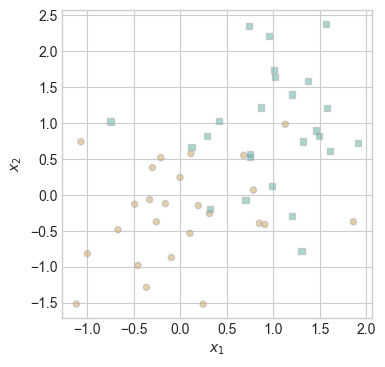

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data(n_points = 50, noise = 0.3, separable = False)
plot_perceptron_data(X, y, ax)

Since the data cannot be perfectly separated, the algorithm will run forever and never reach zero loss. To rectify this we will limit the algorithm to 1000 iterations and plot the final result along with some intermediate results.

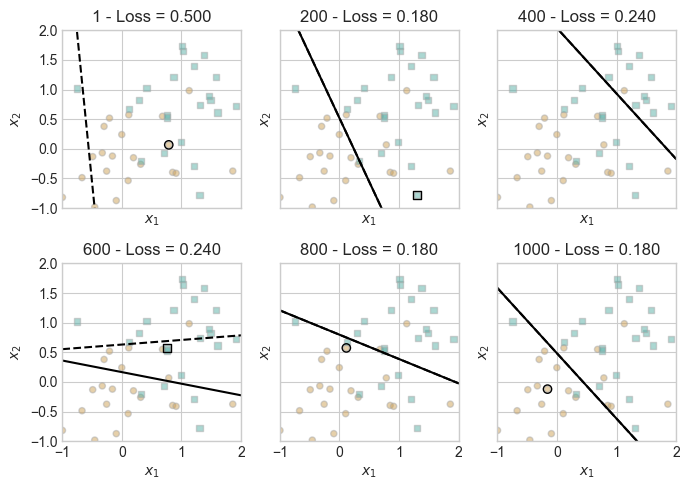

In [ ]:
# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []
to_graph = [0, 199, 399, 599, 799, 999]

for j in range(1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if j in to_graph:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"{j + 1} - Loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

As we see in the plot, the algorithm ran until the maximum number of iterations and the final result has a loss greater than zero. The algorithm was unable to perfectly separate the data as expected. That said, its final result is still a better decision boundary than its initial guess indicating that it was still able to learn and improve.

## Experiment 3
The final experiment involves linearly separable 5-dimensional data. We will create a dataset with 50 points but we cannot plot it due to the high dimensionality. We will run the algorithm and plot the loss over time to see how it converges by plotting the loss over time.

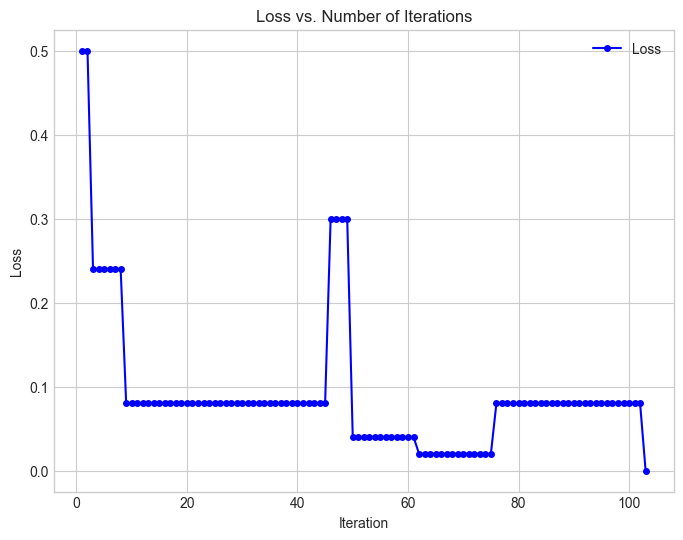

In [ ]:
X, y = perceptron_data(n_points = 50, noise = 0.3, p_dims = 5, separable = True)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# initialize for main loop
loss = 1
loss_vec = []

while loss > 0:
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)

iterations = range(1, len(loss_vec) + 1)  # Create a range for the number of iterations

# Plot the loss vector
plt.figure(figsize=(8, 6))
plt.plot(iterations, loss_vec, marker='o', color='blue', label='Loss', markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Iterations')
plt.grid(True)
plt.legend()
plt.show()

As the plot above shows, the loss decreases over the iterations until it finally reaches zero and the algorithm stops. This indicates that the algorithm was able to perfectly separate the data in the 5-dimensional space so the data was linearly separable.

# Mini-batch Perceptron
The next part involves implementing a mini-batch perceptron algorithm which works by choosing k points for the updates rather than just one as we did above. To do this we need to update the gradient function to account for a learning rate as well as to allow for submatrixes. We use unsqueeze and squeeze to add dimensions making the matrices compatible for matrix multiplication. In our testing loop we also have to update it to select k random points to update the weights. We use randperm to perform this random selection.

## Experiment 1
The first experiment involves linearly separable 2-dimensional data and a k value of 1. The point of this experiment is to ensure that the algorithm is still working as expected and the changes haven't impacted the results.

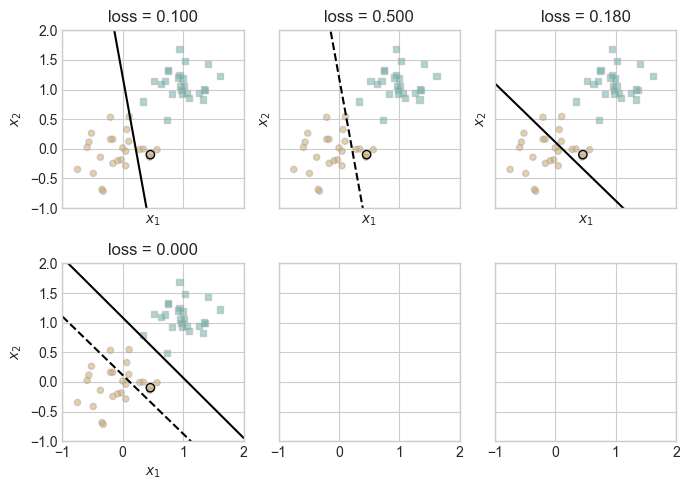

In [ ]:
X, y = perceptron_data(n_points = 50, noise = 0.3, p_dims = 2, separable = True)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
k = 1
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    ix = torch.randperm(X.size(0))[:k]
    X_batch = X[ix, :]
    y_batch = y[ix]
    local_loss = p.loss(X_batch, y_batch).item()

    if local_loss > 0:
        opt.step(X_batch, y_batch)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

As we can see from the above plot, the mini-batch perceptron algorithm is able to correctly work its way to a loss of zero indicating to us that the algorithm still works as intended when it is not doing any batching.

## Experiment 2
Next we want to test the batching on linearly-separable data to see if the algorithm works with batching. We will use a k value of 10 and visualize the results.

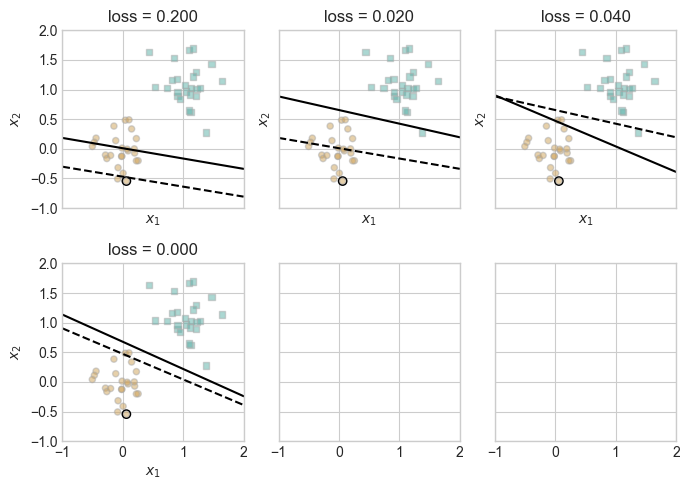

In [ ]:
X, y = perceptron_data(n_points = 50, noise = 0.3, p_dims = 2, separable = True)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
k = 10
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    ix = torch.randperm(X.size(0))[:k]
    X_batch = X[ix, :]
    y_batch = y[ix]
    local_loss = p.loss(X_batch, y_batch).item()

    if local_loss > 0:
        opt.step(X_batch, y_batch)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

As the plot shows, the algorithm is able to correctly separate the data with a batch size of 10. The loss converges to zero and the decision boundary is able to separate the data as expected.

## Experiment 3
The final experiment involves a k value of n where n is the number of data points. We will test this on non linearly separable data to see if it is able to converge. Our convergence test can no longer be a loss of zero since that is impossible with data that is not linearly separable. Instead we will use a maximum number of iterations to stop the algorithm and plot the results to see if we observe convergence.

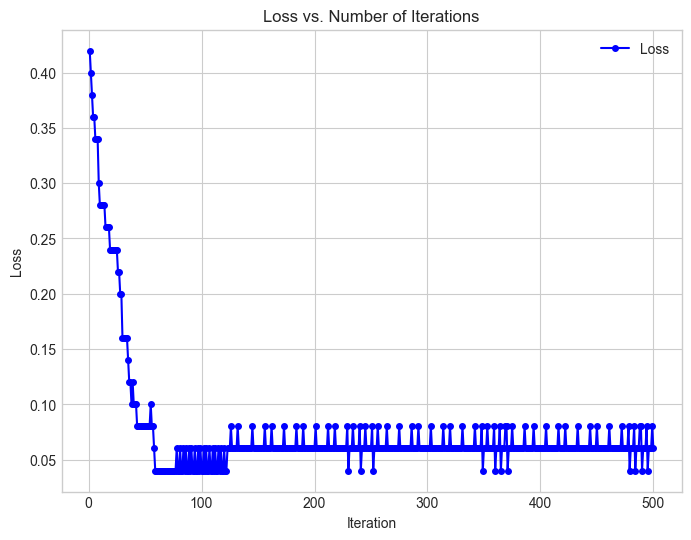

In [ ]:
n = 50
X, y = perceptron_data(n_points = n, noise = 0.3, p_dims = 2, separable = False)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# initialize for main loop
k = n
lr = 0.1
loss = 1
loss_vec = []

for _ in range(500):
    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    ix = torch.randperm(X.size(0))[:k]
    X_batch = X[ix, :]
    y_batch = y[ix]
    local_loss = p.loss(X_batch, y_batch).item()
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

    if local_loss > 0:
        opt.step(X_batch, y_batch, lr)

iterations = range(1, len(loss_vec) + 1)  # Create a range for the number of iterations

# Plot the loss vector
plt.figure(figsize=(8, 6))
plt.plot(iterations, loss_vec, marker='o', color='blue', label='Loss', markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Iterations')
plt.grid(True)
plt.legend()
plt.show()

As we can see, while it does not converge to zero lose, the algorithm is able to converge to a loss of around 0.06. This indicates that the algorithm is able to learn and improve the decision boundary even when the data is not linearly separable and this works with the mini-batching.

## Runtime
A single iteration involves computing the score for a data point which is done with matrix multiplication meaning it takes O(p) time for a data point with p features. It then checks for misclassified points which takes constant O(1) time. For the weight update, the calculation looks at all of the features meaning for each misclassified point it takes O(p) time. This means that the weight update takes O(p) time. Since these steps occur consecutively, the overall runtime is O(p) + O(1) + O(p) which simplifies to O(p) time. For the mini-batch implementation, it also depends on the value of k since it does all of this work for k points at a time. This means that the runtime is O(k x p) time.

# Conclusion
Overall, by implementing the perceptron algorithm we learned a lot about the strengths and weaknesses of this approach to data classification. We saw that with linearly separable data, regardless of the dimension, the algorithm is able to converge to a loss of zero, finding a decision boundary that perfectly separates the data. We also saw that with non-linearly separable data, the algorithm is still able to learn and improve the decision boundary even if it cannot reach a loss of zero. We also saw that the mini-batch perceptron algorithm is able to work with batching and is able to converge to a decision boundary even with non-linearly separable data. This shows that the perceptron algorithm is a simple and efficient algorithm that can be used to classify data into two classes.